# Importation des modules

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random as rd
import seaborn as sns
import typing as tp

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Variables globales

In [21]:
###### Encodeur ######

encoder: dict = {"Anurofeca_richardsi": 0,
                 "Dermocystidium_salmonis": 1,
                 "Ichthyophonus_hoferi": 2,
                 "Pseudoperkinsus_tapetis": 3,
                 "Psorospermium_haeckelii": 4,
                 "Rhinosporidium_cygnus": 5,
                 "Rhinosporidium_seeberi": 6,
                 "Sphaeroforma_spB7": 7,
                 "Sphaeroforma_spCRG3": 8,
                 "Sphaerothecum_destruens": 9,
                 "unidentified": 10}

###### Encodeur ######


###### Datasets ######

species_amplicons: pd.DataFrame = pd.read_csv(filepath_or_buffer="./dataset/fakes_species_amplicons.csv")
randoms_amplicons: pd.DataFrame = pd.read_csv(filepath_or_buffer="./dataset/fakes_unidentified_amplicons.csv")
test_set: pd.DataFrame = pd.read_csv(filepath_or_buffer="./dataset/Sd_testSet_BC06.csv")

###### Datasets ######


###### Paramètres ######

random_state: int = 42
data_size: int =  2000

###### Paramètres ######

# Fonctions utilitaires

In [22]:
def encode(x: str) -> int :
    
    """ Transforme les labels selon l'encodage défini par le dictionnaire 'encoder'. """
    
    # Initialiser la variable globale 
    global encoder
    
    # Retourner l'encodage de la valeur
    return encoder[x]

In [23]:
def plot_data(X: pd.DataFrame, y: pd.DataFrame, n_sample: int=5000, figsize: tuple=(20, 20), save: str=None, palette: list=["turquoise", "crimson"]) -> None :

    """ Plot les données, à partir d'un TSNE. """
    
    # Effectuer le TSNE
    tsne = TSNE(n_components=2, init="pca", learning_rate="auto", random_state=random_state).fit_transform(X=X.iloc[:n_sample], y=y.iloc[:n_sample])
    tsne = pd.concat(objs=[pd.DataFrame(data=tsne), y.iloc[:n_sample].reset_index(drop=True)], axis=1)
    tsne.columns = ['x', 'y', "specie"]

    # Créer la figure le TSNE
    plt.figure(figsize=figsize)

    # Pour chaque espèce
    for i, specie in enumerate(np.unique(tsne["specie"]).tolist(), start=1) :

        # Plotter l'espèce
        plt.subplot(4, 4, i)
        tmp = tsne["specie"].apply(lambda x: specie if x == specie else -1)
        sns.scatterplot(data=tsne, x='x', y='y', hue=tmp, palette=palette)

    # Sauvegarder la figure
    if save != None :
        plt.savefig(save)

    # Afficher l;a figure
    plt.show()

In [24]:
def plot_cm(y_true: pd.DataFrame, y_pred: pd.DataFrame, figsize: tuple=(14, 8), cmap: str="magma_r", save: str=None) -> None :
    
    """ Plot une matrice de confusion. """

    # Calculer la matrice
    cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
    cm = ConfusionMatrixDisplay(confusion_matrix=cm)
    
    # Créer la figure
    _, ax = plt.subplots(figsize=figsize)

    # Plotter la matrice
    cm.plot(ax=ax, cmap=cmap)

    # Sauvegarder la figure
    if save != None :
        plt.savefig(save)

    # Afficher la figure
    plt.show()

In [25]:
def plot_classReport(classifier: object, X: pd.DataFrame, y: pd.DataFrame, figsize: tuple=(14, 8), cmap: str="magma_r", save: str=None) -> None :
    
    """ Affiche les résultats de classification d'un modèle. """

    # Effectuer les prédictions sur les données
    y_pred = classifier.predict(X=X)

    # Afficher le rapport de classification
    print(classification_report(y_true=y, y_pred=y_pred, zero_division=0))

    # Afficher la matrice de confusion
    plot_cm(y_true=y, y_pred=y_pred, figsize=figsize, cmap=cmap, save=save)

In [26]:
def plot_features_importances(classifier: object, figsize: tuple=(14, 10), save: str=None, color: str="blue") -> None :
    
    """ Plotter l'importance de chaque features, sous forme d'un barplot. """

    # Créer la figure
    plt.figure(figsize=figsize)
    
    # Plotter la feature_importances, sous forme de barplot
    pd.Series(data=classifier.feature_importances_, index=[i for i in range(0, len(classifier.feature_importances_), 1)]).plot.bar(color=color)

    # Sauvegarder la figure
    if save != None :
        plt.savefig(save)

    # Afficher la figure
    plt.show()

In [27]:
def print_perfClassifier(classifier: object) -> None :

    """ Affiche la performance d'un classifier. """
    
    # Initialiser les variables globales
    global x_train
    global y_train
    global x_test
    global y_test

    # Plotter les résultats d'entraînement
    plot_classReport(classifier=classifier, X=x_train, y=y_train)

    # Plotter les résultat de prédictions sur le test
    plot_classReport(classifier=classifier, X=x_test, y=y_test)

In [28]:
def test_classifier(classifier: object) -> object :

    """ Test la performance d'un classifier. """

    # Initialiser les variables globales
    global x_train, y_train
    
    # Entrainer le classifer
    clf = classifier.fit(X=x_train, y=y_train)

    # Afficher sa performance
    print_perfClassifier(classifier=clf)

    # Retourner le classifer
    return clf

# Recherche

In [29]:
# Créer le jeu d'entraînement, avec les séquences simulées
train = pd.concat(objs=[species_amplicons, randoms_amplicons], axis=0)

# Séparer les features des labels
features, labels = train.iloc[:, :-1], train.iloc[:, -1].apply(encode)

In [30]:
# Séparer les features et les labels du jeu d'entraînement
x_train, _, y_train, __ = train_test_split(features, labels, train_size=data_size, random_state=random_state, stratify=labels)
display(x_train)

# Séparer les features et les labels du jeu de test
x_test, y_test = test_set.iloc[:, :-1], test_set.iloc[:, -1].apply(encode)
display(x_test)

,0,1,2,3,4,5,6,7,8,9,...,150,151,152,153,154,155,156,157,158,159
29736,4,3,4,4,2,1,1,2,2,3,...,3,4,0,0,0,0,0,0,0,0
53096,4,3,4,4,2,1,1,2,2,3,...,4,3,4,3,1,3,1,3,4,0
61904,4,3,4,4,2,1,1,2,2,3,...,1,4,3,4,3,1,3,1,3,4
42080,4,3,4,4,2,1,1,2,2,3,...,1,3,4,0,0,0,0,0,0,0
17386,4,3,4,4,2,1,1,2,2,3,...,4,3,4,3,1,3,1,3,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33615,4,3,4,4,2,1,1,2,2,3,...,3,4,3,1,3,1,3,4,0,0
45222,4,3,4,4,2,1,1,2,2,3,...,1,3,4,0,0,0,0,0,0,0
39915,4,3,4,4,2,1,1,2,2,3,...,4,3,1,3,1,3,4,0,0,0
87861,4,3,4,4,2,1,1,2,2,3,...,4,3,1,3,1,3,4,0,0,0


,0,1,2,3,4,5,6,7,8,9,...,150,151,152,153,154,155,156,157,158,159
0,4,3,4,4,2,1,1,2,2,3,...,0,0,0,0,0,0,0,0,0,0
1,4,3,4,4,2,1,1,2,2,3,...,4,1,4,2,4,0,0,0,0,0
2,4,3,4,4,2,1,1,2,2,3,...,1,4,2,4,0,0,0,0,0,0
3,4,3,4,4,2,1,1,2,2,3,...,1,4,2,4,0,0,0,0,0,0
4,4,3,4,4,2,1,1,2,2,3,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29497,4,3,4,4,2,1,1,2,2,3,...,4,2,4,0,0,0,0,0,0,0
29498,4,3,4,4,2,1,1,2,2,3,...,2,4,1,4,2,4,0,0,0,0
29499,4,3,4,4,2,1,1,2,2,3,...,2,4,1,4,2,4,0,0,0,0
29500,4,3,4,4,2,1,1,2,2,3,...,4,1,4,2,4,0,0,0,0,0


c:\Users\Utilisateur\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


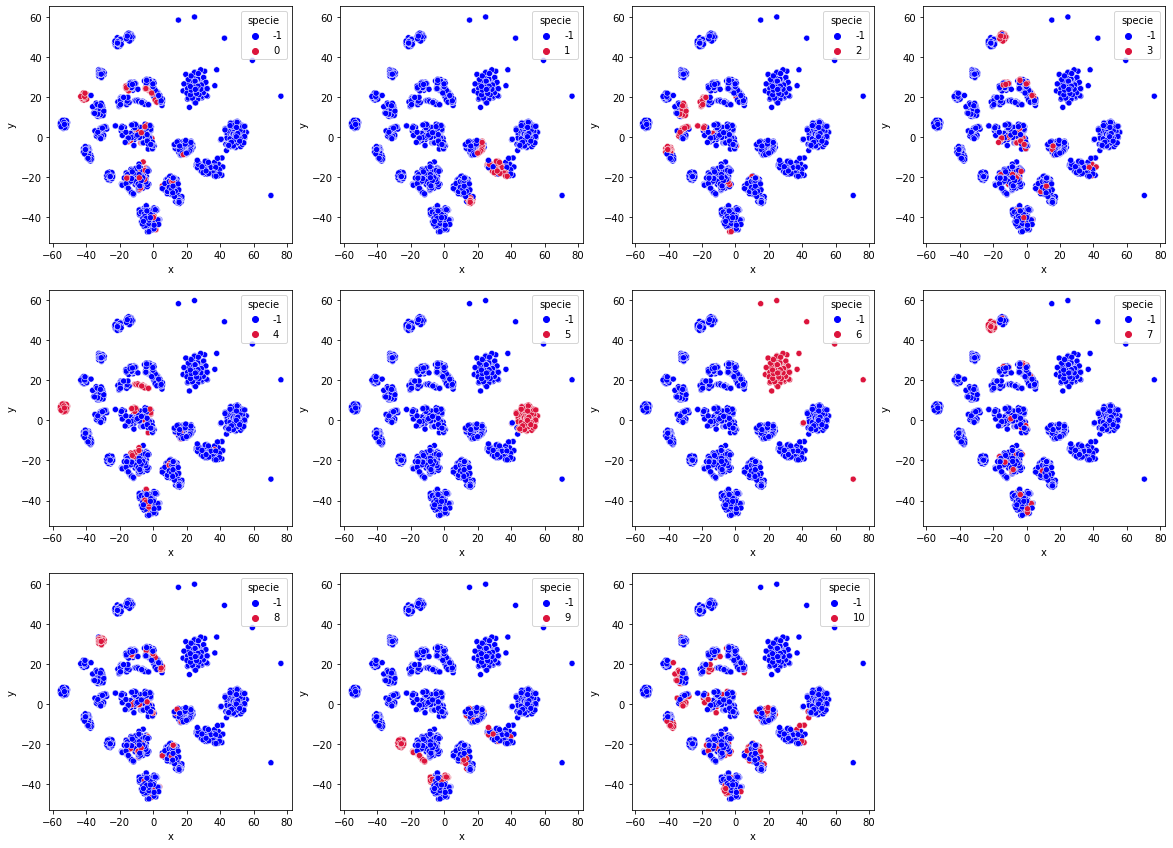

In [31]:
# Plotter le jeu d'entraînement
plot_data(X=x_train, y=y_train, palette=["blue", "crimson"], n_sample=data_size)

# Test des différents classifieurs

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       182
           1       1.00      1.00      1.00       182
           2       0.99      0.99      0.99       182
           3       0.96      0.92      0.94       181
           4       1.00      1.00      1.00       182
           5       1.00      0.99      1.00       182
           6       1.00      1.00      1.00       181
           7       0.93      0.94      0.94       182
           8       0.96      1.00      0.98       182
           9       1.00      1.00      1.00       182
          10       0.99      1.00      1.00       182

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000



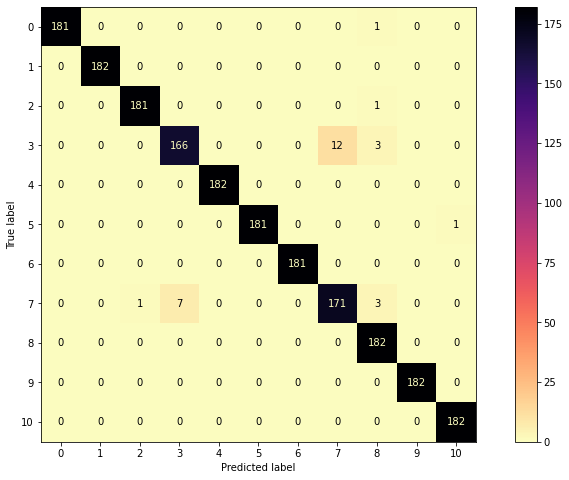

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       1.00      0.51      0.67     29502
          10       0.00      0.00      0.00         0

    accuracy                           0.51     29502
   macro avg       0.12      0.06      0.08     29502
weighted avg       1.00      0.51      0.67     29502



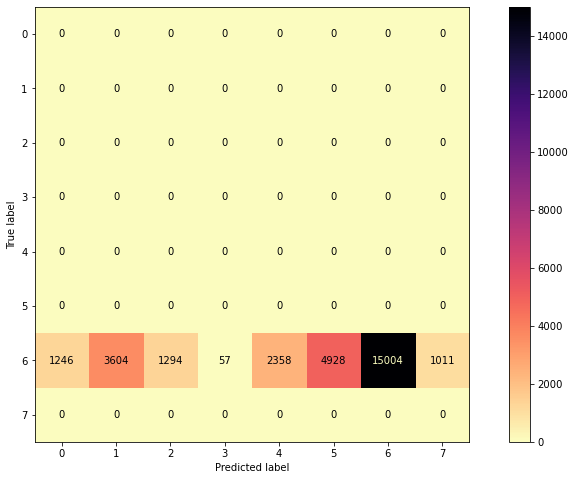

In [32]:
svc: SVC = test_classifier(classifier=SVC(random_state=random_state))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       182
           1       1.00      1.00      1.00       182
           2       1.00      1.00      1.00       182
           3       0.99      0.99      0.99       181
           4       1.00      1.00      1.00       182
           5       1.00      1.00      1.00       182
           6       1.00      1.00      1.00       181
           7       0.99      0.99      0.99       182
           8       1.00      1.00      1.00       182
           9       1.00      1.00      1.00       182
          10       1.00      1.00      1.00       182

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



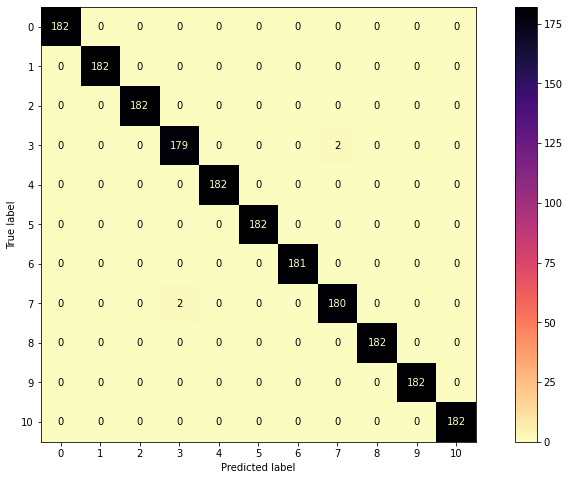

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       1.00      0.58      0.73     29502
          10       0.00      0.00      0.00         0

    accuracy                           0.58     29502
   macro avg       0.09      0.05      0.07     29502
weighted avg       1.00      0.58      0.73     29502



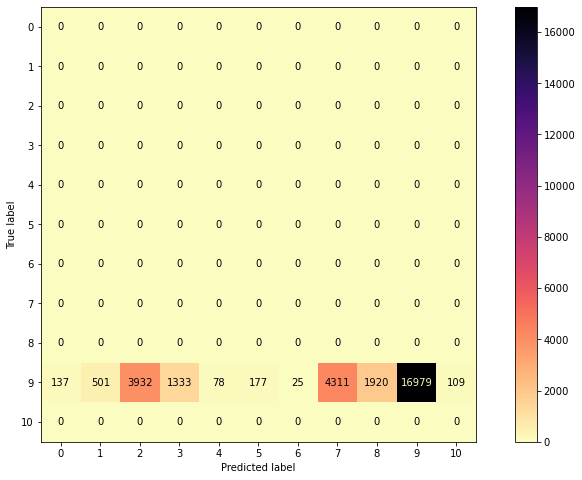

In [33]:
lgr: LogisticRegression = test_classifier(classifier=LogisticRegression(random_state=random_state, max_iter=10000))

              precision    recall  f1-score   support

           0       0.84      0.53      0.65       182
           1       0.70      0.77      0.73       182
           2       0.97      0.85      0.91       182
           3       0.45      0.35      0.40       181
           4       0.97      0.75      0.84       182
           5       0.97      0.99      0.98       182
           6       0.81      0.97      0.88       181
           7       0.46      0.38      0.42       182
           8       0.43      0.40      0.41       182
           9       0.53      0.81      0.64       182
          10       0.73      0.96      0.83       182

    accuracy                           0.71      2000
   macro avg       0.71      0.71      0.70      2000
weighted avg       0.71      0.71      0.70      2000



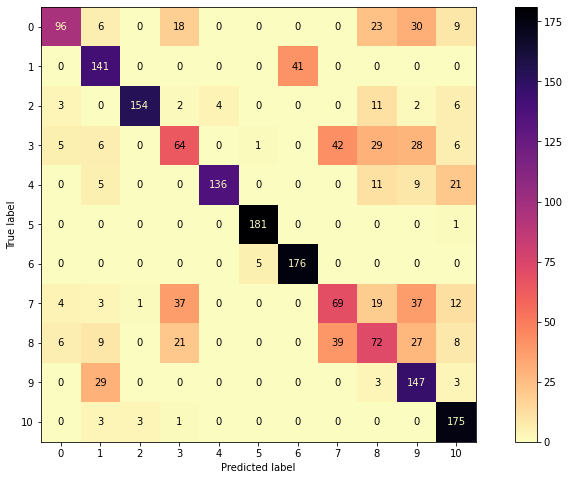

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       1.00      0.28      0.43     29502
          10       0.00      0.00      0.00         0

    accuracy                           0.28     29502
   macro avg       0.09      0.03      0.04     29502
weighted avg       1.00      0.28      0.43     29502



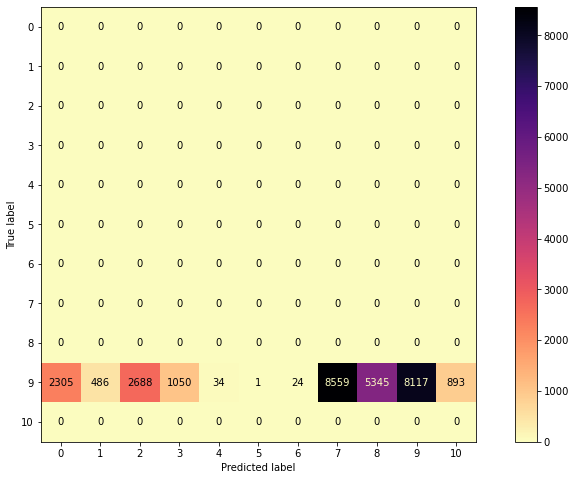

In [34]:
mlb: MultinomialNB = test_classifier(classifier=MultinomialNB())

              precision    recall  f1-score   support

           0       0.85      0.95      0.90       182
           1       0.90      1.00      0.95       182
           2       0.90      0.97      0.93       182
           3       0.71      0.78      0.74       181
           4       0.95      0.98      0.96       182
           5       0.98      0.98      0.98       182
           6       0.99      1.00      0.99       181
           7       0.77      0.75      0.76       182
           8       0.87      0.85      0.86       182
           9       0.96      0.95      0.95       182
          10       1.00      0.59      0.74       182

    accuracy                           0.89      2000
   macro avg       0.90      0.89      0.89      2000
weighted avg       0.90      0.89      0.89      2000



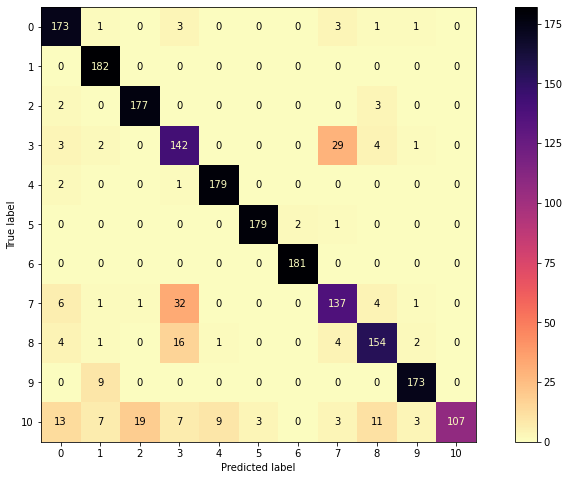

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       1.00      0.53      0.69     29502
          10       0.00      0.00      0.00         0

    accuracy                           0.53     29502
   macro avg       0.09      0.05      0.06     29502
weighted avg       1.00      0.53      0.69     29502



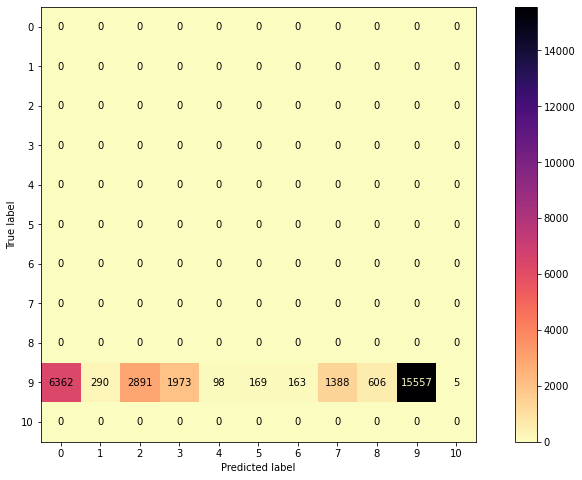

In [35]:
knn: KNeighborsClassifier = test_classifier(classifier=KNeighborsClassifier())

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       182
           1       1.00      1.00      1.00       182
           2       1.00      1.00      1.00       182
           3       1.00      1.00      1.00       181
           4       1.00      1.00      1.00       182
           5       1.00      1.00      1.00       182
           6       1.00      1.00      1.00       181
           7       1.00      1.00      1.00       182
           8       1.00      1.00      1.00       182
           9       1.00      1.00      1.00       182
          10       1.00      1.00      1.00       182

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



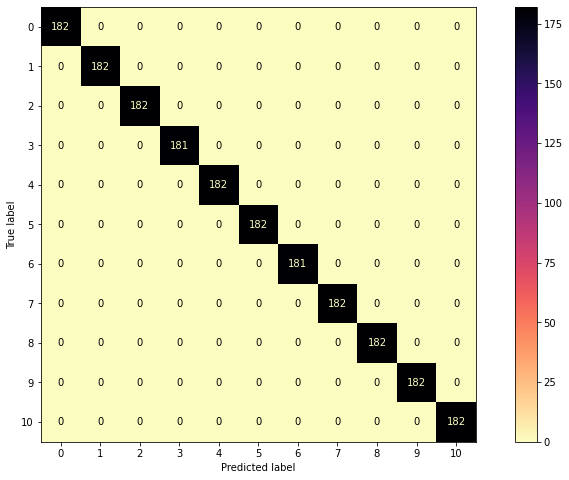

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       1.00      0.28      0.43     29502
          10       0.00      0.00      0.00         0

    accuracy                           0.28     29502
   macro avg       0.09      0.03      0.04     29502
weighted avg       1.00      0.28      0.43     29502



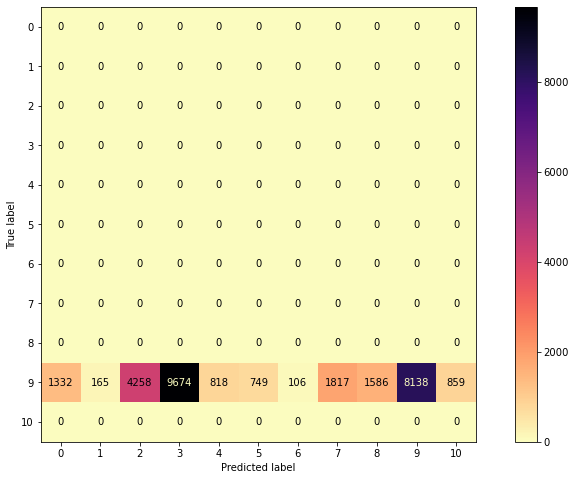

In [36]:
dtc: DecisionTreeClassifier = test_classifier(classifier=DecisionTreeClassifier(random_state=random_state))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       182
           1       1.00      1.00      1.00       182
           2       1.00      1.00      1.00       182
           3       1.00      1.00      1.00       181
           4       1.00      1.00      1.00       182
           5       1.00      1.00      1.00       182
           6       1.00      1.00      1.00       181
           7       1.00      1.00      1.00       182
           8       1.00      1.00      1.00       182
           9       1.00      1.00      1.00       182
          10       1.00      1.00      1.00       182

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



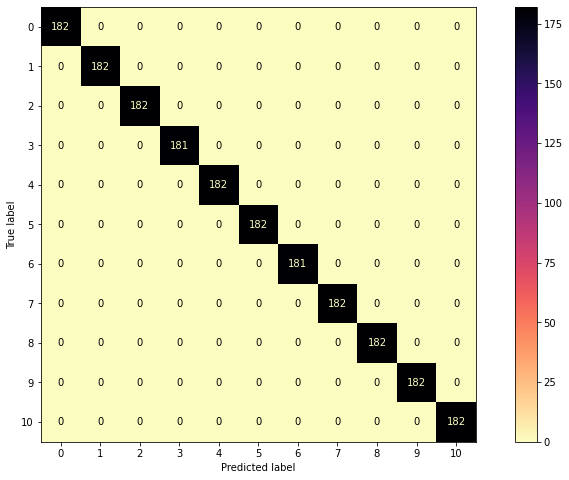

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       1.00      0.67      0.81     29502
          10       0.00      0.00      0.00         0

    accuracy                           0.67     29502
   macro avg       0.09      0.06      0.07     29502
weighted avg       1.00      0.67      0.81     29502



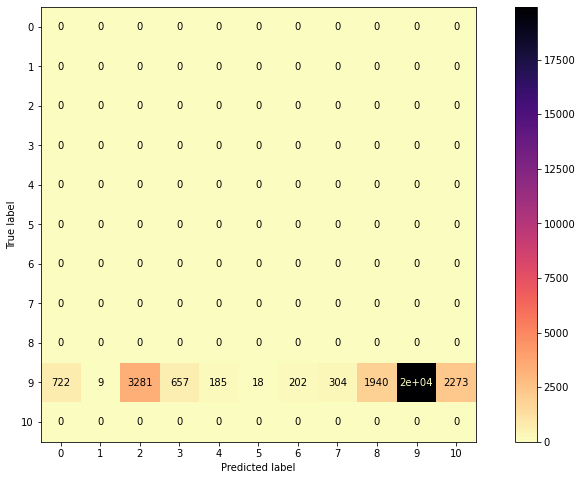

In [37]:
rfc: RandomForestClassifier = test_classifier(classifier=RandomForestClassifier(random_state=random_state))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       182
           1       1.00      1.00      1.00       182
           2       1.00      1.00      1.00       182
           3       1.00      1.00      1.00       181
           4       1.00      1.00      1.00       182
           5       1.00      1.00      1.00       182
           6       1.00      1.00      1.00       181
           7       1.00      1.00      1.00       182
           8       1.00      1.00      1.00       182
           9       1.00      1.00      1.00       182
          10       1.00      1.00      1.00       182

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



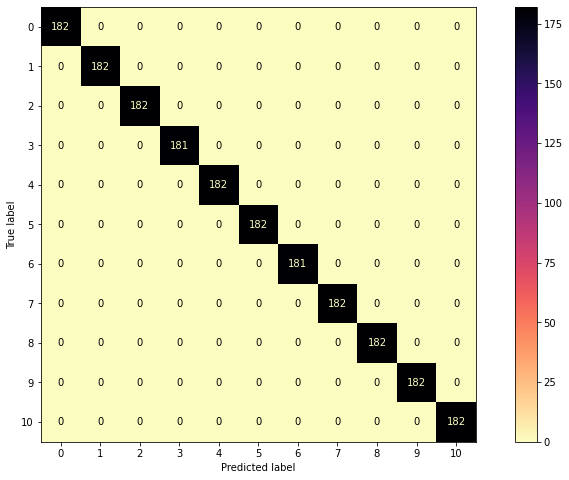

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       1.00      0.74      0.85     29502
          10       0.00      0.00      0.00         0

    accuracy                           0.74     29502
   macro avg       0.09      0.07      0.08     29502
weighted avg       1.00      0.74      0.85     29502



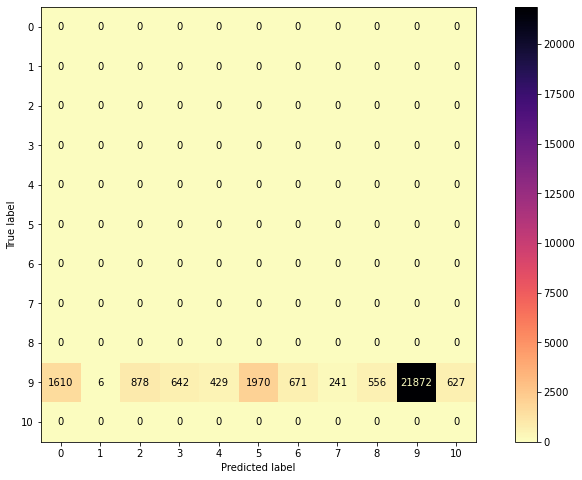

In [38]:
xgb: XGBClassifier = test_classifier(classifier=XGBClassifier(random_state=random_state))